In [20]:
import pandas as pd

dataset = pd.read_csv('./sample-VQ-BDQ-1-egtm.csv')

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor

In [22]:
Y = dataset[['egtm', 'n1_delt', 'n2_delt']]

X = dataset.drop(columns=[
    'reportts', 'acnum', 'pos', 'dep', 'arr', 'egtm',
    'dmusw', 'exswpn', 'reason', 'recordedts'
]).fillna(-100)

X = X.loc[:, ~X.columns.str.contains('stw')]

In [23]:
def get_score_by_parameter(predict_field):
  y = Y[predict_field]

  x = X[y.notna()]

  y = y.dropna()
  
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
  
  model = CatBoostRegressor(iterations=200, verbose=False)
  model.fit(X_train, y_train)
  catboost_predicted = model.predict(X_test)
  catboost_score = mean_squared_error(y_test, catboost_predicted, squared=False)
  return catboost_score, model

In [24]:
scores = pd.DataFrame(columns=["parameter", "rmse", ".0", ".1", ".5", ".9", "1"])
models = []
output_parameters = Y.columns

for param in output_parameters:
  score, model = get_score_by_parameter(param)
  models.append(model)
  qua = Y[param].quantile([.0, .1, .5, .9, 1])
  qua = list(qua)
  scores.loc[len(scores)] = [param, score] + qua

scores

,parameter,rmse,.0,.1,.5,.9,1
0,egtm,0.887848,106.186000,106.917000,107.440000,114.441800,132.144000
1,n1_delt,0.004915,-0.160004,-0.110001,-0.079994,-0.040001,0.220001
2,n2_delt,0.005050,-0.330100,-0.267799,-0.199750,-0.113995,-0.067051


<Axes: ylabel='Frequency'>

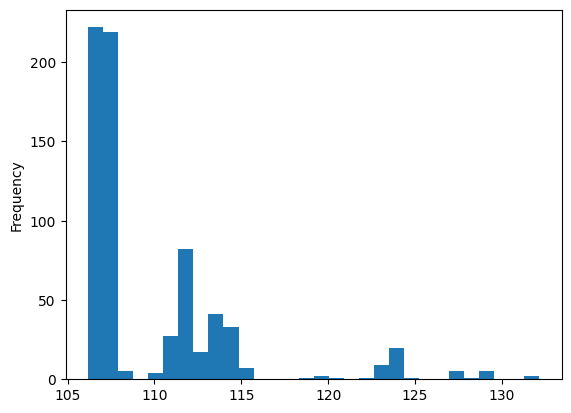

In [25]:
Y['egtm'].plot.hist(bins=30)

In [31]:
model = models[1]


catboost_predicted = model.predict(X[100:200])


pd.DataFrame({'n1_delt': Y['n1_delt'][100:200], 'pred': catboost_predicted})


,n1_delt,pred
100,-0.129997,-0.129570
101,-0.089996,-0.090004
102,-0.089996,-0.090568
103,-0.080002,-0.080008
104,-0.059998,-0.059865
...,...,...
195,-0.049995,-0.049517
196,-0.070000,-0.070890
197,-0.070000,-0.071744
198,-0.070000,-0.068738


In [28]:
model = models[0]


catboost_predicted = model.predict(X)

pd.DataFrame({'egtm': Y['egtm'], 'pred': catboost_predicted})

,egtm,pred
0,132.144,132.075903
1,132.144,132.001370
2,127.592,126.738438
3,128.712,128.765988
4,129.118,129.111883
...,...,...
700,106.968,107.399007
701,106.968,106.956418
702,106.968,106.922045
703,106.968,106.955484
